In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [3]:
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})

In [4]:
# --- OEM 8-class legend info (official OEM colours) ---
OEM8_HEX = {
    1: "#800000",  # Bareland
    2: "#00FF24",  # Rangeland
    3: "#949494",  # Developed space
    4: "#FFFFFF",  # Road
    5: "#226126",  # Tree
    6: "#0045FF",  # Water
    7: "#4BB549",  # Agriculture land
    8: "#DE1F07",  # Building
}

OEM8_NAMES = {
    1: "Bareland",
    2: "Rangeland",
    3: "Developed space",
    4: "Road",
    5: "Tree",
    6: "Water",
    7: "Agriculture land",
    8: "Building",
}

PLOT_IDS = list(OEM8_NAMES.keys())
LABELS = [OEM8_NAMES[k] for k in PLOT_IDS]
Y = np.arange(len(PLOT_IDS))


In [5]:
from pathlib import Path
import os

p = Path.cwd().resolve()
for _ in range(10):
    if (p / "data").is_dir() and (p / "scripts").is_dir():
        REPO_ROOT = p
        break
    if p == p.parent:
        raise RuntimeError("Could not find repo root")
    p = p.parent

os.chdir(REPO_ROOT)
print("Repo root:", REPO_ROOT)

MASK_DIR = REPO_ROOT / "data/openearthmap_filtered/masks"
assert MASK_DIR.exists(), "OEM filtered masks not found"


Repo root: /home/lainey/Documents/Github/ClassImbalance


In [6]:
import rasterio
import numpy as np

# collect all OEM filtered masks (TIFFs, optionally PNGs if present)
mask_paths = sorted(MASK_DIR.glob("*.tif")) + sorted(MASK_DIR.glob("*.png"))
assert len(mask_paths) > 0, f"No OEM masks found in {MASK_DIR}"

tile_counts = {k: 0 for k in PLOT_IDS}
pixel_counts = {k: 0 for k in PLOT_IDS}
total_pixels = 0

for p in mask_paths:
    # --- read mask robustly ---
    if p.suffix.lower() in [".tif", ".tiff"]:
        with rasterio.open(p) as src:
            mask = src.read(1)
    else:  # png fallback
        mask = np.array(Image.open(p))

    total_pixels += mask.size
    unique = np.unique(mask)

    for k in PLOT_IDS:
        if k in unique:
            tile_counts[k] += 1
        pixel_counts[k] += np.sum(mask == k)

n_tiles = len(mask_paths)

tile_proportion = np.array([tile_counts[k] / n_tiles for k in PLOT_IDS])
pixel_proportion = np.array([pixel_counts[k] / total_pixels for k in PLOT_IDS])

print("Tiles:", n_tiles)
print("Tile proportions:", tile_proportion)
print("Pixel proportions:", pixel_proportion)


Tiles: 1362
Tile proportions: [0.16519824 0.97283407 0.9743025  0.94566814 0.99265786 0.59324523
 0.24449339 0.96402349]
Pixel proportions: [0.02537343 0.14839045 0.18447044 0.08301245 0.23477085 0.05085891
 0.02127367 0.24311782]


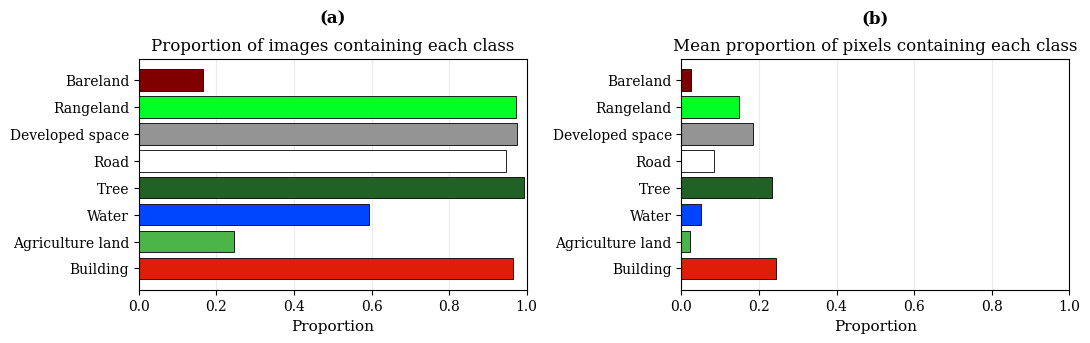

In [7]:
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(11, 3.6)
)

fig.subplots_adjust(wspace=0.25)

# -------- Panel (a): proportion of tiles --------
ax = axes[0]
ax.barh(
    Y,
    tile_proportion,
    color=[OEM8_HEX[k] for k in PLOT_IDS],
    edgecolor="black",
    linewidth=0.6
)

ax.set_yticks(Y)
ax.set_yticklabels(LABELS)
ax.invert_yaxis()
ax.set_xlim(0, 1.0)
ax.set_xlabel("Proportion")
ax.set_title("Proportion of images containing each class")
ax.text(0.5, 1.14, "(a)", transform=ax.transAxes,
        ha="center", va="bottom", fontsize=12, fontweight="bold")
ax.grid(True, axis="x", alpha=0.25)
ax.set_axisbelow(True)

# -------- Panel (b): proportion of pixels --------
ax = axes[1]
ax.barh(
    Y,
    pixel_proportion,
    color=[OEM8_HEX[k] for k in PLOT_IDS],
    edgecolor="black",
    linewidth=0.6
)



ax.set_yticks(Y)
ax.set_yticklabels(LABELS)
ax.invert_yaxis()
ax.set_xlim(0, 1.0)
ax.set_xlabel("Proportion")
ax.set_title("Mean proportion of pixels containing each class")
ax.text(0.5, 1.14, "(b)", transform=ax.transAxes,
        ha="center", va="bottom", fontsize=12, fontweight="bold")
ax.grid(True, axis="x", alpha=0.25)
ax.set_axisbelow(True)

out_path = REPO_ROOT / "outputs/figures/fig2_oem_class_distribution.pdf"
out_path.parent.mkdir(parents=True, exist_ok=True)

fig.tight_layout()
fig.savefig(out_path, bbox_inches="tight")
plt.show()
